In [280]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [281]:
cyclists_data = pd.read_csv("dataset/cyclists.csv",index_col=0)
races_data = pd.read_csv("dataset/races.csv",index_col=0)
cyclists_data.info()
cyclists_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         6134 non-null   object 
 1   birth_year   6121 non-null   float64
 2   weight       3078 non-null   float64
 3   height       3143 non-null   float64
 4   nationality  6133 non-null   object 
 5   cyclist_id   6134 non-null   object 
dtypes: float64(3), object(3)
memory usage: 335.5+ KB


,name,birth_year,weight,height,nationality,cyclist_id
0,Bruno Surra,1964.0,NaN,NaN,Italy,bruno-surra
1,Gérard Rué,1965.0,74.0,182.0,France,gerard-rue
2,Jan Maas,1996.0,69.0,189.0,Netherlands,jan-maas
3,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium,nathan-van-hooydonck
4,José Félix Parra,1997.0,55.0,171.0,Spain,jose-felix-parra


In [282]:
races_data.info()
races_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist_age          589752 non-null  float64
 12  is_tarmac            589865 non-null  bool   
 13  is_cobbled           589865 non-null  bool   
 14  is_gravel            589865 non-null  bool   
 15  cyclist_team         4

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,cyclist_id
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0,sean-kelly
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,27.0,True,False,False,norway-1987,0.0,gerrie-knetemann
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,24.0,True,False,False,NaN,0.0,rene-bittinger
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,30.0,True,False,False,navigare-blue-storm-1993,0.0,joseph-bruyere
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,27.0,True,False,False,spain-1991,0.0,sven-ake-nilsson


# 1. Data Processing

## 1.1 Categorical variables,  normalizing and standarizing

In [283]:
# Define function to categorize 'position'
# This will later be the label for our classifiers
def categorize_position(pos):
    if pos <= 3:
        return "0"#Podium
    elif pos <= 20:
        return "1"#Top20
    elif pos <= 50:
        return "2"#Top50
    elif pos <= 100:
        return "3"#Top100
    else:
        return "4"#Remaining

# Apply categorization
races_data["position_category"] = races_data["position"].apply(categorize_position)

# Check distribution of categories
position_distribution = races_data["position_category"].value_counts(normalize=True) * 100

position_distribution


position_category
4    31.518737
3    31.315301
2    20.382121
1    13.207429
0     3.576412
Name: proportion, dtype: float64

In [284]:
# Identify float64 columns
float_cols = races_data.select_dtypes(include=['float64']).columns

# Convert float64 to int, handling NaN values
for col in float_cols:
    if col in ['points', 'climb_total', 'uci_points', 'length', 'cyclist_age', 'delta']:  # Specify columns that should be int
        races_data[col] = races_data[col].fillna(0).astype(int)  # Replace NaN with 0 before conversion

# Check the new data types
print(races_data.dtypes)

_url                    object
name                    object
points                   int64
uci_points               int64
length                   int64
climb_total              int64
profile                float64
startlist_quality        int64
average_temperature    float64
date                    object
position                 int64
cyclist_age              int64
is_tarmac                 bool
is_cobbled                bool
is_gravel                 bool
cyclist_team            object
delta                    int64
cyclist_id              object
position_category       object
dtype: object


In [285]:
# Nationality from object to category
cyclists_data['nationality'] = cyclists_data['nationality'].astype('category')

# Convert the 'cyclist_team' column to category type
races_data['cyclist_team'] = races_data['cyclist_team'].astype('category')
# Convert the 'cyclists_age' column to int32 type
races_data['cyclist_age'] = races_data['cyclist_age'].astype('int32')

# Correcting some type castings that are unnecesary in races dataset
races_data['points'] = races_data['points'].astype(int)
races_data['length'] = races_data['length'].astype(int)
races_data['delta'] = races_data['delta'].astype(int)
races_data['cyclist_age'] = races_data['cyclist_age'].astype(int)
races_data['cyclist_id'] = races_data['cyclist_id'].astype('string')

# Split _url into into ['race_name', 'year', 'stage'] by /
races_data[['race_name', 'year', 'stage']] = races_data['_url'].str.split('/', expand=True)
races_data = races_data.drop(columns=['_url'])
#races_data['stage'] = races_data['stage'].astype('string')
races_data['year'] = races_data['year'].astype(int)

# Now we have 2 columns with race_name
races_data = races_data.drop(columns=['name'])

# Extract month from date and remove date
# Year already from _url and we discard day and hour
races_data['date'] = pd.to_datetime(races_data['date'])
races_data['month'] = races_data['date'].dt.month
races_data = races_data.drop(columns=['date'])

# climb_total and profile are highly correlated, so we combine them
races_data['aug_profile'] = np.where(
    races_data['climb_total'].notna() & races_data['profile'].notna(),
    races_data['climb_total'] / races_data['climb_total'].max() + races_data['profile'],
    np.nan  # Assign NaN if either column is still missing
)
races_data = races_data.drop(columns=['climb_total'])
races_data = races_data.drop(columns=['profile'])

In [286]:
# Encode categorical values of races df
categorical_cols = ['cyclist_team', 'race_name', 'stage']
encoder = LabelEncoder()

for col in categorical_cols:
    races_data[col] = encoder.fit_transform(races_data[col])
    
cyclists_data['nationality'] = encoder.fit_transform(cyclists_data['nationality'])

In [287]:
# Always: is_tarmac= true, is_cobbled=False, is_gravel=False
races_data = races_data.drop(columns=['is_tarmac', 'is_cobbled', 'is_gravel'])

## 1.2 Managing missing values

In [288]:
cyclists_data.info()
cyclists_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         6134 non-null   object 
 1   birth_year   6121 non-null   float64
 2   weight       3078 non-null   float64
 3   height       3143 non-null   float64
 4   nationality  6134 non-null   int64  
 5   cyclist_id   6134 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 335.5+ KB


,name,birth_year,weight,height,nationality,cyclist_id
0,Bruno Surra,1964.0,NaN,NaN,34,bruno-surra
1,Gérard Rué,1965.0,74.0,182.0,24,gerard-rue
2,Jan Maas,1996.0,69.0,189.0,46,jan-maas
3,Nathan Van Hooydonck,1995.0,78.0,192.0,7,nathan-van-hooydonck
4,José Félix Parra,1997.0,55.0,171.0,60,jose-felix-parra


In [289]:
# We dont need name with id
cyclists_data = cyclists_data.drop(columns=['name'])

In [290]:
# Checkimg (and removing if there were any) duplicates in both datasets
duplicated_races = races_data[races_data.duplicated(keep=False)]
print(duplicated_races.shape)

duplicated_cyclists = cyclists_data[cyclists_data.duplicated(keep=False)]
print(duplicated_cyclists.shape)

(0, 16)
(0, 5)


In [291]:
print(cyclists_data.shape)
print("Number of null in cyclists dataset")
print("----------------------------------")
print(cyclists_data.isnull().sum(),'\n')

print("Percentage of null in cyclists dataset")
print("----------------------------------")
print(round(cyclists_data.isnull().sum()*100/cyclists_data.shape[0],2).astype(str) + '%')

(6134, 5)
Number of null in cyclists dataset
----------------------------------
birth_year       13
weight         3056
height         2991
nationality       0
cyclist_id        0
dtype: int64 

Percentage of null in cyclists dataset
----------------------------------
birth_year      0.21%
weight         49.82%
height         48.76%
nationality      0.0%
cyclist_id       0.0%
dtype: object


In [292]:
cyclists_data_imp_mean = cyclists_data.copy()
cyclists_data_imp_mean['birth_year'].fillna(cyclists_data_imp_mean['birth_year'].mean(), inplace=True)
cyclists_data_imp_mean['weight'].fillna(cyclists_data_imp_mean['weight'].mean(), inplace=True)
cyclists_data_imp_mean['height'].fillna(cyclists_data_imp_mean['height'].mean(), inplace=True)

cyclists_data_imp_median = cyclists_data.copy()
cyclists_data_imp_median['birth_year'].fillna(cyclists_data_imp_median['birth_year'].mean(), inplace=True)
cyclists_data_imp_median['weight'].fillna(cyclists_data_imp_median['weight'].mean(), inplace=True)
cyclists_data_imp_median['height'].fillna(cyclists_data_imp_median['height'].mean(), inplace=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_944\764782506.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cyclists_data_imp_mean['birth_year'].fillna(cyclists_data_imp_mean['birth_year'].mean(), inplace=True)
C:\Users\angel\AppData\Local\Temp\ipykernel_944\764782506.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [293]:
print("Correlation between columns")
print("----------------------------------")
print('Weight-Height\t',cyclists_data['weight'].corr(cyclists_data['height']))
print('Weight-Birth Year\t',cyclists_data['weight'].corr(cyclists_data['birth_year']))
print('Height-Birth Year\t',cyclists_data['height'].corr(cyclists_data['birth_year']))

Correlation between columns
----------------------------------
Weight-Height	 0.7207320842827667
Weight-Birth Year	 -0.10424159211777138
Height-Birth Year	 0.15425242554298202


### Cylists imputation

In [294]:
# Make a copy of the original DataFrame
cyclists_data_imp_iter = cyclists_data.copy()

# Select only numerical columns
num_cols = cyclists_data_imp_iter.select_dtypes(include=['number']).columns
cyclists_num = cyclists_data_imp_iter[num_cols]

# Apply IterativeImputer only to numerical columns
imp_iter = IterativeImputer(random_state=0)
cyclists_num_imp = imp_iter.fit_transform(cyclists_num)

# Convert the result back into a DataFrame
cyclists_num_imp_df = pd.DataFrame(cyclists_num_imp, columns=num_cols, index=cyclists_data_imp_iter.index)

# Replace only numerical columns in the original DataFrame
for col in num_cols:
    cyclists_data_imp_iter[col] = cyclists_num_imp_df[col]

# Check for remaining missing values
print("\nMissing values after imputation:")
print(cyclists_data_imp_iter.isnull().sum())

# Display some rows to verify the changes
print("\nAfter imputation:")
print(cyclists_data_imp_iter.head())



Missing values after imputation:
birth_year     0
weight         0
height         0
nationality    0
cyclist_id     0
dtype: int64

After imputation:
   birth_year     weight      height  nationality            cyclist_id
0      1964.0  69.291718  177.789845         34.0           bruno-surra
1      1965.0  74.000000  182.000000         24.0            gerard-rue
2      1996.0  69.000000  189.000000         46.0              jan-maas
3      1995.0  78.000000  192.000000          7.0  nathan-van-hooydonck
4      1997.0  55.000000  171.000000         60.0      jose-felix-parra


### Merge

In [295]:
merged_df = races_data.merge(cyclists_data_imp_iter, on='cyclist_id', how='outer')

In [296]:
merged_df = merged_df.drop(columns=['cyclist_id'])

In [297]:
merged_df.head()

,points,uci_points,length,startlist_quality,average_temperature,position,cyclist_age,cyclist_team,delta,position_category,race_name,year,stage,month,aug_profile,birth_year,weight,height,nationality
0,100.0,0.0,162000.0,1241.0,NaN,84.0,27.0,91.0,27.0,3,20.0,1978.0,44.0,7.0,1.157872,1951.0,77.0,186.0,46.0
1,100.0,0.0,52000.0,1241.0,NaN,83.0,27.0,91.0,823.0,3,20.0,1978.0,12.0,7.0,5.193720,1951.0,77.0,186.0,46.0
2,50.0,0.0,30000.0,388.0,NaN,0.0,30.0,91.0,0.0,0,24.0,1981.0,34.0,9.0,NaN,1951.0,77.0,186.0,46.0
3,100.0,0.0,254000.0,1362.0,NaN,133.0,30.0,91.0,258.0,4,20.0,1981.0,26.0,6.0,1.501864,1951.0,77.0,186.0,46.0
4,100.0,0.0,231000.0,1362.0,NaN,94.0,30.0,91.0,614.0,3,20.0,1981.0,13.0,7.0,4.573559,1951.0,77.0,186.0,46.0


In [298]:
print(merged_df.isnull().sum(),'\n')

points                     39
uci_points                 39
length                     39
startlist_quality          39
average_temperature    559971
position                   39
cyclist_age                39
cyclist_team               39
delta                      39
position_category          39
race_name                  39
year                       39
stage                      39
month                      39
aug_profile            148233
birth_year                  0
weight                      0
height                      0
nationality                 0
dtype: int64 



### Train, test split

In [299]:
merged_df['year'].max() 

np.float64(2023.0)

In [300]:
test = merged_df[merged_df['year'] >= 2020]
train  = merged_df[(merged_df['year'] < 2020)]

test_percentage = test.shape[0] / merged_df.shape[0] * 100
train_percentage = train.shape[0] / merged_df.shape[0] * 100

In [301]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 523937 entries, 0 to 589903
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   points               523937 non-null  float64
 1   uci_points           523937 non-null  float64
 2   length               523937 non-null  float64
 3   startlist_quality    523937 non-null  float64
 4   average_temperature  0 non-null       float64
 5   position             523937 non-null  float64
 6   cyclist_age          523937 non-null  float64
 7   cyclist_team         523937 non-null  float64
 8   delta                523937 non-null  float64
 9   position_category    523937 non-null  object 
 10  race_name            523937 non-null  float64
 11  year                 523937 non-null  float64
 12  stage                523937 non-null  float64
 13  month                523937 non-null  float64
 14  aug_profile          375743 non-null  float64
 15  birth_year           5

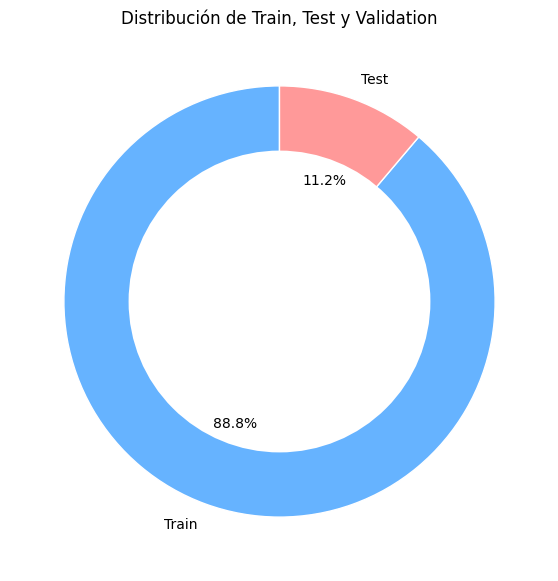

In [302]:
labels = ['Train', 'Test']
sizes = [train_percentage, test_percentage]
colors = ['#66b3ff', '#ff9999']  # Colores para cada segmento

# Crear la figura y el gráfico de dona
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'white'})

# Agregar un círculo en el centro para convertirlo en donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Título
plt.title("Distribución de Train, Test y Validation")
plt.show()

### Standarize and encode

In [306]:
num_cols = train.select_dtypes(include=['number']).columns

# Aplicar StandardScaler
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

# Convertir float64 a float32
train[train.select_dtypes(include=['float64']).columns] = train.select_dtypes(include=['float64']).astype(np.float32)
test[test.select_dtypes(include=['float64']).columns] = test.select_dtypes(include=['float64']).astype(np.float32)

# Convertir int64 a int32
train[train.select_dtypes(include=['int64']).columns] = train.select_dtypes(include=['int64']).astype(np.int32)
test[test.select_dtypes(include=['int64']).columns] = test.select_dtypes(include=['int64']).astype(np.int32)

c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\angel\AppData\Local\Temp\ipykernel_944\493573514.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[num_cols] = sc

In [307]:
train.head()

,points,uci_points,length,startlist_quality,average_temperature,position,cyclist_age,cyclist_team,delta,position_category,race_name,year,stage,month,aug_profile,birth_year,weight,height,nationality
0,0.187142,-0.344571,-0.079861,0.315477,NaN,0.201071,-0.381014,1.058098,-0.437546,3,0.443781,-2.452239,1.114715,0.563259,-1.056768,-2.314108,1.543359,1.225549,0.532361
1,0.187142,-0.344571,-1.763267,0.315477,NaN,0.180582,-0.381014,1.058098,0.481699,3,0.443781,-2.452239,-0.743267,0.563259,1.399560,-2.314108,1.543359,1.225549,0.532361
2,-0.730729,-0.344571,-2.099948,-1.909081,NaN,-1.520035,0.410076,1.058098,-0.468726,0,0.939523,-2.171679,0.534095,1.607295,NaN,-2.314108,1.543359,1.225549,0.532361
3,0.187142,-0.344571,1.328079,0.631035,NaN,1.205050,0.410076,1.058098,-0.170780,4,0.443781,-2.171679,0.069600,0.041240,-0.847405,-2.314108,1.543359,1.225549,0.532361
4,0.187142,-0.344571,0.976094,0.631035,NaN,0.405965,0.410076,1.058098,0.240339,3,0.443781,-2.171679,-0.685205,0.563259,1.022113,-2.314108,1.543359,1.225549,0.532361


### Races imputation

<Axes: >

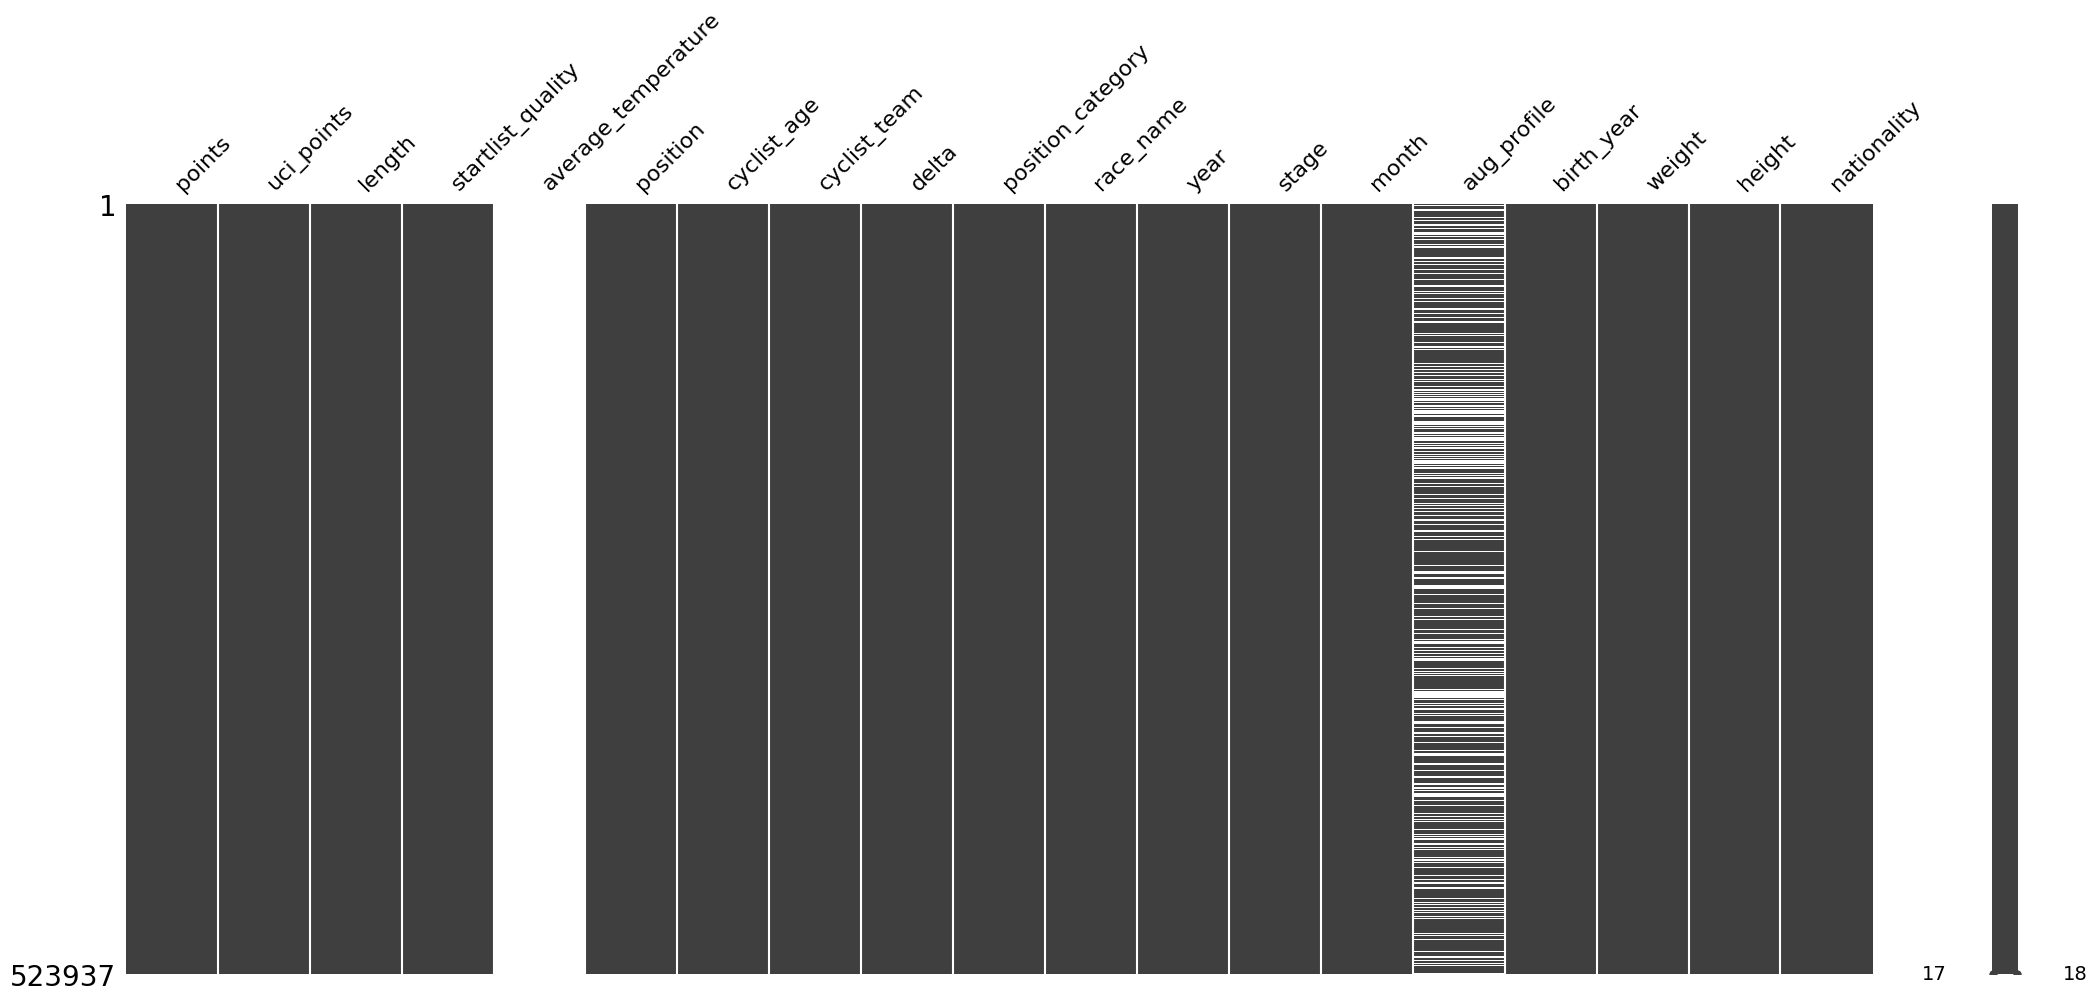

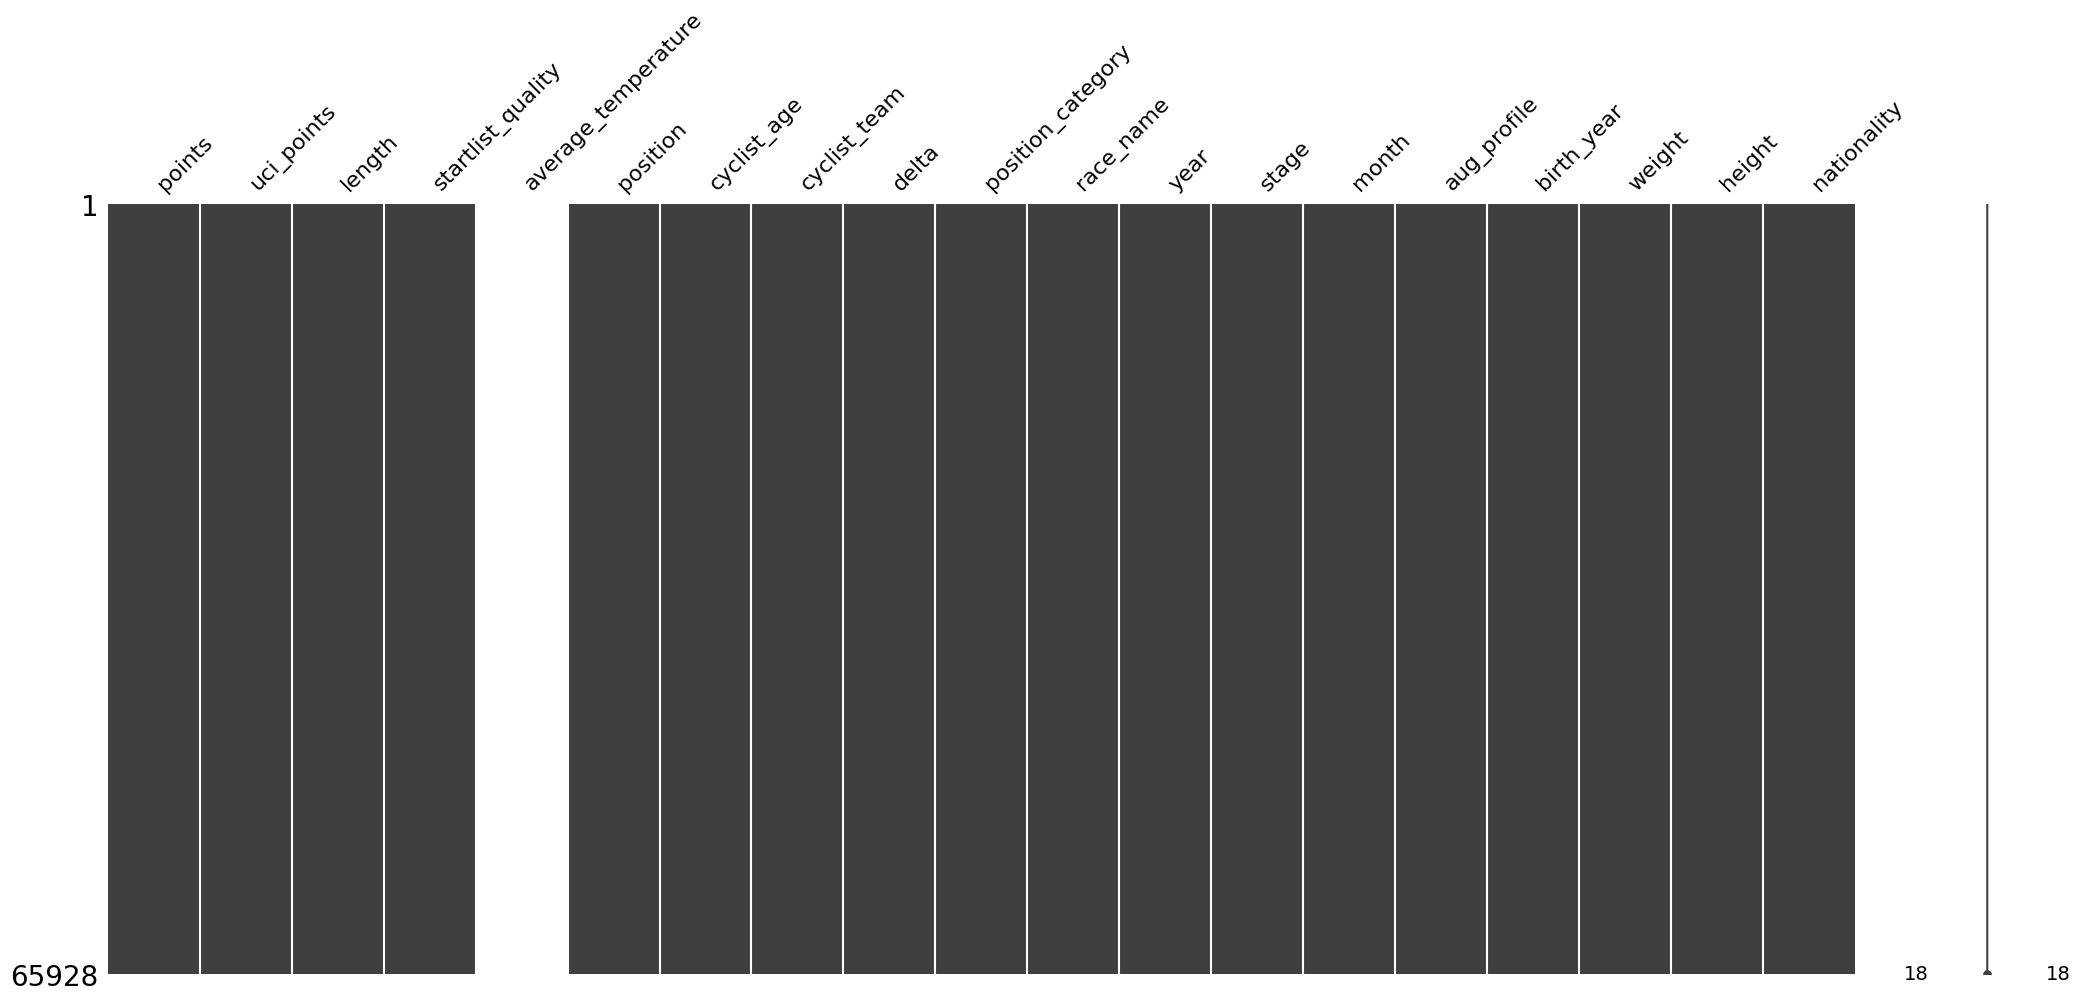

In [317]:
msno.matrix(train)
msno.matrix(test)

In [318]:
# It has almost 100% of data loss, so we decided to drop it
train = train.drop(columns=['average_temperature'])
test = test.drop(columns=['average_temperature'])

## 1.3 Training Models

In [314]:
from imblearn.over_sampling import SMOTE, ADASYN


ModuleNotFoundError: No module named 'imblearn'